<a href="https://colab.research.google.com/github/bertoramos/GAN-MNIST/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GAN : Generative Adversarial Network

In [1]:
import os

os.system('rm -r ./*') # remove all content in current directory DRIVE

0

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime


### Dataset

In [3]:

BUFFER_SIZE = 60_000
BATCH_SIZE  = 256

def create_dataset():
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    
    return train_dataset

### GAN : create models

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def create_generator():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

def create_discriminator():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model


#### Loss and optimizers

In [5]:
def generator_loss(disc_decision):
    return cross_entropy(tf.ones_like(disc_decision), disc_decision)

def discriminator_loss(real_image_decision, fake_image_decision):
    real_image_loss = cross_entropy(tf.ones_like(real_image_decision), real_image_decision)
    fake_image_loss = cross_entropy(tf.zeros_like(fake_image_decision), fake_image_decision)
    return real_image_loss + fake_image_loss

def create_generator_optimizer():
    return keras.optimizers.Adam(1e-4)

def create_discriminator_optimizer():
    return keras.optimizers.Adam(1e-4)

### Creating GAN class

In [9]:
noise_dim = 100


class GAN:
    
    def __init__(self):
        self.__generator = create_generator()
        self.__discriminator = create_discriminator()
        
        self.__generator_opt = create_generator_optimizer()
        self.__discriminator_opt = create_discriminator_optimizer()
    
    #@tf.function
    def train_step(self, images):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.__generator(noise, training=True)
            
            real_output = self.__discriminator(images, training=True)
            fake_output = self.__discriminator(generated_images, training=True)
            
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
        
        grad_generator = gen_tape.gradient(gen_loss, self.__generator.trainable_variables)
        grad_discriminator = disc_tape.gradient(disc_loss, self.__discriminator.trainable_variables)
        
        self.__generator_opt.apply_gradients(zip(grad_generator, self.__generator.trainable_variables))
        self.__discriminator_opt.apply_gradients(zip(grad_discriminator, self.__discriminator.trainable_variables))
    
    def train(self, dataset, epochs):
        for ep in range(epochs):
            for batch in tqdm(dataset, desc='Epoch {}'.format(ep)):
                self.train_step(batch)
    
    def generate(self):
      noise = tf.random.normal([BATCH_SIZE, noise_dim])

      generated_images = self.__generator(noise, training=False)
      return generated_images

    def load():
      pass
    
    def save(self, path):
      dt = datetime.now()
      fmt = 'Y{}M{}D{}H{}M{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute)
      generator_file = path + '/GAN_{}/generator'.format(fmt)
      discriminator_file = path + '/GAN_{}/discriminator'.format(fmt)
      self.__generator.save(generator_file)
      self.__discriminator.save(discriminator_file)


### Training

##### GAN instance

In [50]:
EPOCHS = 80
datasets = create_dataset()
gan = GAN()


##### Train

In [52]:
gan.train(datasets, EPOCHS)

gan.save('./drive/My Drive')

Streaming output truncated to the last 5000 lines.


Epoch 72: 224it [00:37,  5.93it/s]


Epoch 72: 225it [00:37,  6.01it/s]


Epoch 72: 226it [00:37,  6.01it/s]


Epoch 72: 227it [00:38,  6.06it/s]


Epoch 72: 228it [00:38,  6.00it/s]


Epoch 72: 229it [00:38,  5.93it/s]


Epoch 72: 230it [00:38,  5.96it/s]


Epoch 72: 231it [00:38,  6.02it/s]


Epoch 72: 232it [00:38,  5.97it/s]


Epoch 72: 233it [00:39,  5.96it/s]


Epoch 72: 234it [00:39,  5.96it/s]


Epoch 72: 235it [00:39,  5.96it/s]



Epoch 73: 0it [00:00, ?it/s]


Epoch 73: 1it [00:00,  2.58it/s]


Epoch 73: 2it [00:00,  3.12it/s]


Epoch 73: 3it [00:00,  3.65it/s]


Epoch 73: 4it [00:00,  4.16it/s]


Epoch 73: 5it [00:01,  4.61it/s]


Epoch 73: 6it [00:01,  4.93it/s]


Epoch 73: 7it [00:01,  5.22it/s]


Epoch 73: 8it [00:01,  5.41it/s]


Epoch 73: 9it [00:01,  5.61it/s]


Epoch 73: 10it [00:01,  5.68it/s]


Epoch 73: 11it [00:02,  5.84it/s]


Epoch 73: 12it [00:02,  5.93it/s]


Epoch 73: 13it [00:02,  5.95it/s]


Epoch 73: 14

INFO:tensorflow:Assets written to: ./drive/My Drive/GAN_Y2020M8D3H11M57/generator/assets
INFO:tensorflow:Assets written to: ./drive/My Drive/GAN_Y2020M8D3H11M57/discriminator/assets


### Load models

In [16]:
#generator = keras.models.load_model('./drive/My Drive/GAN_Y2020M8D3H10M11/generator')

#discriminator = keras.models.load_model('./drive/My Drive/GAN_Y2020M8D3H10M11/discriminator')

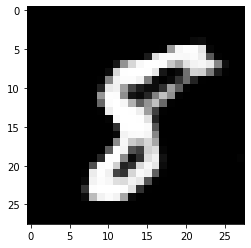

In [87]:
generated_image = gan.generate()

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
